## 

#### Imports

In [7]:
import pandas as pd
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 1. Connect to Database

In [ ]:
user = 'postgres'
password = urllib.parse.quote_plus('your_password')  # replace with your actual password
host = 'localhost'
port = '5432'
db = 'postgres'  

engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db}')

## 2. Load Data into Pandas

In [9]:
students = pd.read_sql("SELECT * FROM public.students;", engine)
instructors = pd.read_sql("SELECT * FROM public.instructors;", engine)
courses = pd.read_sql("SELECT * FROM public.courses;", engine)
lessons = pd.read_sql("SELECT * FROM public.lessons;", engine)
enrollments = pd.read_sql("""
    SELECT e.enrollment_id, e.student_id, e.course_id, e.enrolled_on, 
           e.completed, e.grade,
           s.full_name AS student_name, 
           c.title AS course_title,
           i.full_name AS instructor_name
    FROM public.enrollments e
    JOIN students s ON e.student_id = s.student_id
    JOIN courses c ON e.course_id = c.course_id
    JOIN instructors i ON c.instructor_id = i.instructor_id;
""", engine)

students.head(), enrollments.head()

(   student_id       full_name               email   joined_on
 0           1      Liam Smith    liam.s@email.com  2022-01-15
 1           2  Olivia Johnson  olivia.j@email.com  2022-01-20
 2           3   Noah Williams    noah.w@email.com  2022-02-05
 3           4      Emma Brown    emma.b@email.com  2022-02-11
 4           5    Oliver Jones  oliver.j@email.com  2022-03-01,
    enrollment_id  student_id  course_id enrolled_on  completed  grade  \
 0              1           1          1  2023-01-10       True   92.5   
 1              2           1          3  2023-02-15       True   88.0   
 2              3           2          2  2023-01-20      False    NaN   
 3              4           3          1  2023-02-01       True   95.0   
 4              5           3          2  2023-02-05       True   91.2   
 
      student_name                                  course_title  \
 0      Liam Smith         The Complete Web Development Bootcamp   
 1      Liam Smith  Python for Data Sci

## 3. Exploratory Data Analysis (EDA)

#### (a) Top 10 Most Enrolled Courses

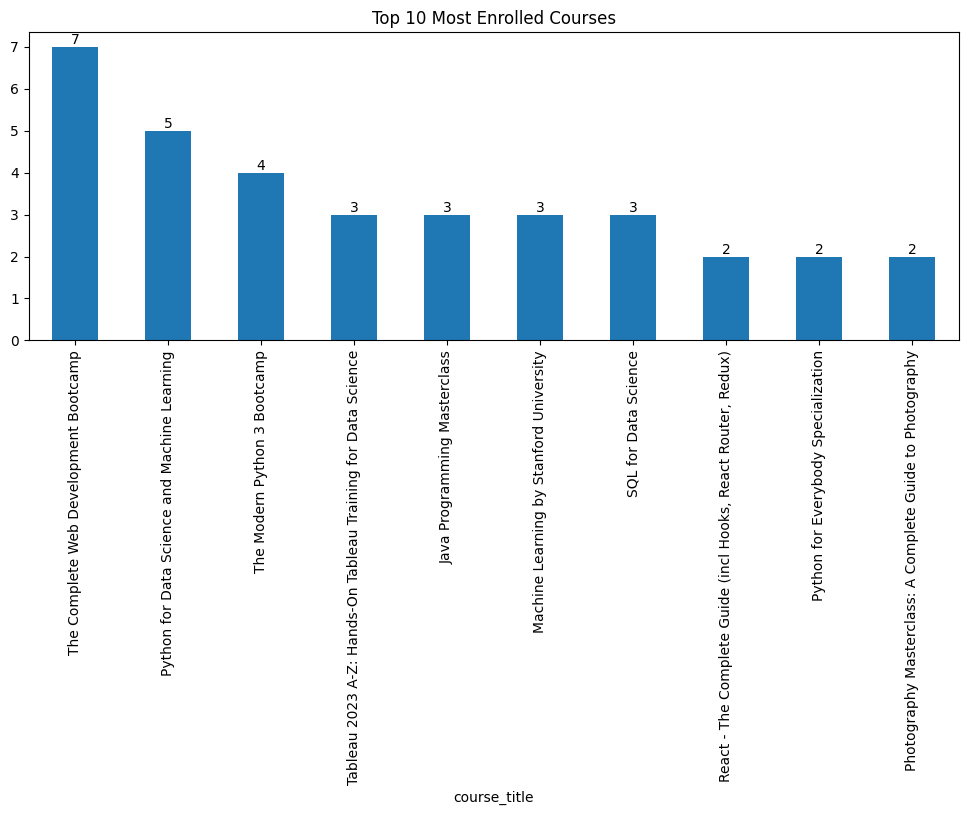

In [10]:
course_counts = enrollments['course_title'].value_counts().head(10)

ax = course_counts.plot(kind='bar', figsize=(12,4))
plt.title("Top 10 Most Enrolled Courses")

for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()

#### **Key Insights**:

- Most Popular Course: The most popular course by a significant margin is "The Complete Web Development Bootcamp," with 7 enrollments.

- Top Tier Subjects: Following the top course, subjects related to Python and Data Science are highly popular. "Python for Data Science and Machine Learning" has 5 enrollments, and "The Modern Python 3 Bootcamp" has 4.

- Strong Demand for Tech: A clear trend is the strong demand for technical skills. Courses on Java, Tableau, SQL, and Machine Learning all appear in the top 10, each having 3 enrollments.

- Other Popular Areas: While tech courses dominate, other subjects also make the list, with "Photography Masterclass" showing a notable presence with 2 enrollments.

In summary, the chart indicates that web development and data science are the primary drivers of enrollments, highlighting the most valuable subjects on the platform.

#### (b) Grade Distribution (histogram)

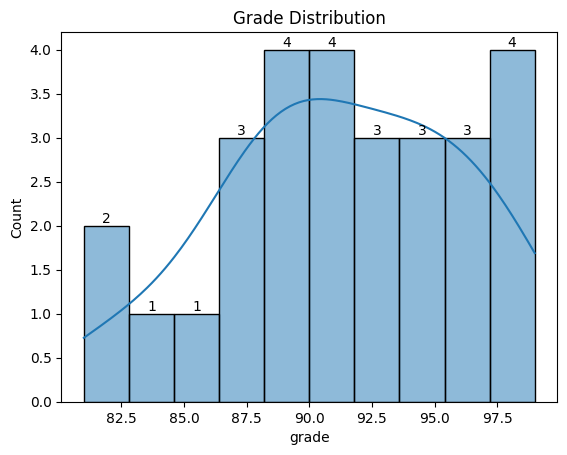

In [11]:
ax = sns.histplot(enrollments['grade'].dropna(), bins=10, kde=True)
plt.title("Grade Distribution")

# Add labels for each bar (patch)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height,
                int(height), ha="center", va="bottom")

plt.show()

#### **Key Insights**:

- High Overall Performance: The vast majority of grades are high, clustered between 87.5 and 99. This indicates that students who complete courses generally do very well.

- Bimodal Distribution: The most interesting feature is that the distribution is bimodal, meaning it has two distinct peaks. This suggests there might be two different performance groups.

  - The first and largest peak is around the 90-point mark, where a total of 8 students scored.

  - A second, equally high peak appears at the top end, around 97.5, where 4 students achieved top marks.

- Few Lower Scores: There are very few students in the lower-scoring brackets, with only two students scoring in the low 80s.

In conclusion, the data shows that student performance isn't a simple bell curve. Instead, there appear to be two main groups: a large group of high-achieving students and a smaller group of top-performing students.

#### (c) Completion Rate per Course (horizontal bars)

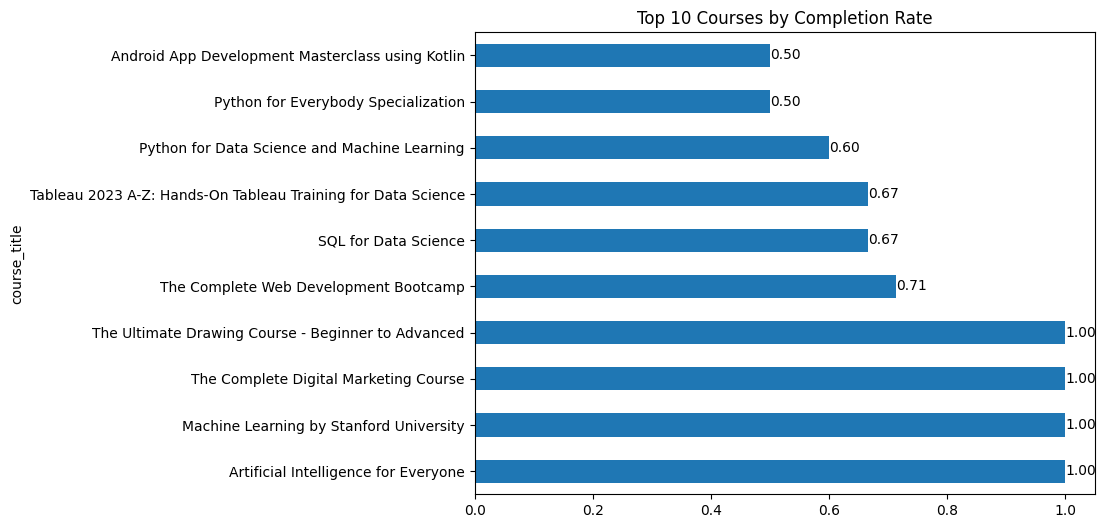

In [12]:
completion_rate = enrollments.groupby("course_title")["completed"].mean().sort_values(ascending=False).head(10)

ax = completion_rate.plot(kind="barh", figsize=(8,6))
plt.title("Top 10 Courses by Completion Rate")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

#### **Key Insights**:

- The completion rates vary between 0.50 and 1.00.

- Four courses—The Ultimate Drawing Course - Beginner to Advanced, The Complete Digital Marketing Course, Machine Learning by Stanford University, and Artificial Intelligence for Everyone, have the highest completion rate of 1.00, indicating that 100% of participants completed these courses.

- The Complete Web Development Bootcamp follows with a completion rate of 0.71.

- SQL for Data Science and Tableau 2023 A-Z: Hands-On Tableau Training for Data Science both have a completion rate of 0.67.

- Python for Data Science and Machine Learning has a completion rate of 0.60.

- Python for Everybody Specialization and Android App Development Masterclass using Kotlin have the lowest completion rates at 0.50 each.

This suggests that courses in drawing, digital marketing, machine learning, and artificial intelligence have the highest engagement and completion, while programming and app development courses may face higher dropout rates.


## 4. Supervised Learning (Logistic Regression)

In [13]:
# 🔹 Make a copy so you don't mutate the original
df_ml = enrollments.copy()

# Convert 'completed' to int (True -> 1, False -> 0)
df_ml['completed'] = df_ml['completed'].astype(int)

# Keep only rows where we have grades
df_ml = df_ml.dropna(subset=['grade'])

# ----- OPTION A: Use completed if it has both classes -----
if df_ml['completed'].nunique() >= 2:
    print("Using 'completed' as target variable")
    X = df_ml[['grade', 'course_id', 'student_id']]
    y = df_ml['completed']

# ----- OPTION B: Create a derived target if no diversity -----
else:
    print("'completed' has only one class. Using a derived target: high_grade >= 85")
    df_ml['high_grade'] = (df_ml['grade'] >= 85).astype(int)  # pick your own threshold
    X = df_ml[['grade', 'course_id', 'student_id']]
    y = df_ml['high_grade']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

'completed' has only one class. Using a derived target: high_grade >= 85

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Confusion Matrix:
[[1 0]
 [0 5]]


## 5. Unsupervised Learning (KMeans Clustering)

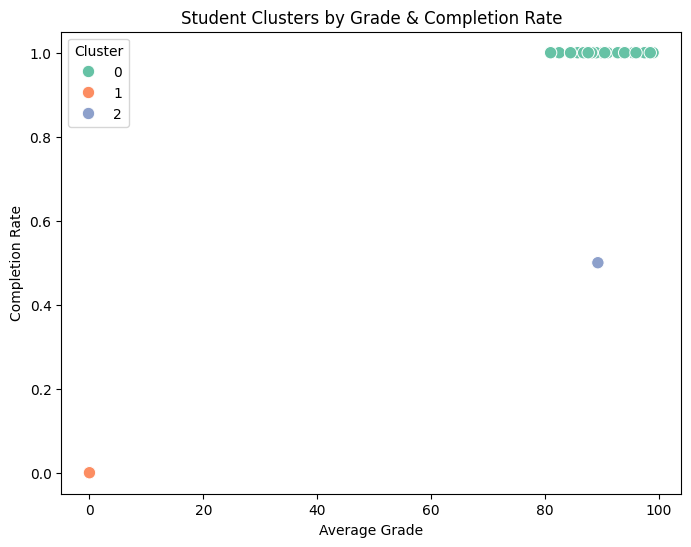


Cluster centers (original scale):
      avg_grade  completion_rate  courses_enrolled
0  9.133696e+01     1.000000e+00               1.0
1 -7.105427e-15     2.220446e-16               1.0
2  9.088333e+01     8.333333e-01               2.0


In [14]:
# 1️⃣ Build features per student: average grade & completion rate & #courses
student_features = (
    enrollments
    .groupby('student_id')
    .agg(
        avg_grade=('grade','mean'),
        completion_rate=('completed','mean'),
        courses_enrolled=('course_id','nunique')
    )
    .fillna(0)
)

# 2️⃣ Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(student_features)

# 3️⃣ KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
student_features['cluster'] = clusters

# 4️⃣ Plot: average grade vs completion rate colored by cluster
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='avg_grade',
    y='completion_rate',
    hue='cluster',
    data=student_features,
    palette='Set2',
    s=80
)
plt.title('Student Clusters by Grade & Completion Rate')
plt.xlabel('Average Grade')
plt.ylabel('Completion Rate')
plt.legend(title='Cluster')
plt.show()

# 5️⃣ (Optional) see cluster centers back in original scale
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=student_features.columns[:-1]
)
print("\nCluster centers (original scale):")
print(centers)